# Freddie Mac Single Family Loan Classification

Build an LightGBM model To predict whether a loan will be a bad one using the data collected when the loan is (was) originated. (Comparing to XGBoost, LightGBM may treat categrocal features better.)

Data available from Freddie Mac ([Single Family Loan-Level Dataset](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)). Loan with a term of 30 years originated between 1999 and 2003 are selected, so we are looking back from about 15 years away, and only completed/terminated loans are used. 
Good loans have been fully paid-off, while a bad one was terminated by other reasons.

This project is inspired by [Matthew C. F. Tso](https://towardsdatascience.com/predicting-bad-housing-loans-using-public-freddie-mac-data-a-tutorial-on-working-with-imbalanced-d2852c003996), but focus on the LightGBM modelling and the three ways to deal with imbalanced dataset. The main differences or modification include:
* The ROC-AUC is calculated correctly using the predicted probability instead of the classification.
* The validation set and testing set are well seprated from the training set now, avoiding data bleeding.
* All validation/testing is made on the unmodified data, allowing for direct comparison of different models.
* An optimal threshold is determined based on the balanced accuracy score of the validation set, instead of a fixed value of 0.5. (This enables the direct comparison as mentioned above.)
* Minor: rewrite the functions to make the output more accessible 

Again, I did not tune the parameters, which is not the goal of this project and I do not believe there will be a huge improvement.

A brief summary is in the [Summary Section](#summary) of the notebook.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)

from zipfile import ZipFile

import pandas as pd

import numpy as np 
from scipy import stats

import random

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

### Get the Data

* Original dataset download from Freddie Mac's [Single Family Loan-Level Dataset](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)
* Will replace the specific values with NaN according to the user guide
* Save dataset to csv locally for convinience in the future

In [2]:
# copied from the README

header_orig = \
"""CREDIT SCORE
FIRST PAYMENT DATE
FIRST TIME HOMEBUYER FLAG
MATURITY DATE
METROPOLITAN STATISTICAL AREA
MORTGAGE INSURANCE PERCENTAGE
NUMBER OF UNITS
OCCUPANCY STATUS
ORIGINAL COMBINED LOAN-TO-VALUE
ORIGINAL DEBT-TO-INCOME RATIO
ORIGINAL UPB
ORIGINAL LOAN-TO-VALUE
ORIGINAL INTEREST RATE
CHANNEL
PREPAYMENT PENALTY MORTGAGE FLAG
PRODUCT TYPE
PROPERTY STATE
PROPERTY TYPE
POSTAL CODE
LOAN SEQUENCE NUMBER
LOAN PURPOSE
ORIGINAL LOAN TERM
NUMBER OF BORROWERS
SELLER NAME
SERVICER NAME
SUPER CONFORMING FLAG
Pre-HARP LOAN SEQUENCE NUMBER """

header_svcg = \
"""LOAN SEQUENCE NUMBER
MONTHLY REPORTING PERIOD
CURRENT ACTUAL UPB
CURRENT LOAN DELINQUENCY STATUS
LOAN AGE
REMAINING MONTHS TO LEGAL MATURITY
REPURCHASE FLAG
MODIFICATION FLAG
ZERO BALANCE CODE
ZERO BALANCE EFFECTIVE DATE
CURRENT INTEREST RATE
CURRENT DEFERRED UPB
DUE DATE OF LAST PAID INSTALLMENT
MI RECOVERIES
NET SALES PROCEEDS
NON MI RECOVERIES
EXPENSES
LEGAL COSTS
MAINTENANCE AND PRESERVATION COSTS
TAXES AND INSURANCE
MISCELLANEOUS EXPENSES
ACTUAL LOSS CALCULATION
MIDIFICATION COST
STEP MODIFICATION FLAG
DEFERRED PAYMENT MODIFICATION
ESTIMATED LOAN TO VALUE
ZERO BALANCE REMOVAL UPB
DELINQUENT ACCRUED INTEREST"""

header_orig = [s.strip().title().replace(' ', '').replace('-','') for s in header_orig.split('\n')]
header_svcg = [s.strip().title().replace(' ', '').replace('-','') for s in header_svcg.split('\n')]

In [3]:
print(header_orig)
print(header_svcg)

['CreditScore', 'FirstPaymentDate', 'FirstTimeHomebuyerFlag', 'MaturityDate', 'MetropolitanStatisticalArea', 'MortgageInsurancePercentage', 'NumberOfUnits', 'OccupancyStatus', 'OriginalCombinedLoanToValue', 'OriginalDebtToIncomeRatio', 'OriginalUpb', 'OriginalLoanToValue', 'OriginalInterestRate', 'Channel', 'PrepaymentPenaltyMortgageFlag', 'ProductType', 'PropertyState', 'PropertyType', 'PostalCode', 'LoanSequenceNumber', 'LoanPurpose', 'OriginalLoanTerm', 'NumberOfBorrowers', 'SellerName', 'ServicerName', 'SuperConformingFlag', 'PreHarpLoanSequenceNumber']
['LoanSequenceNumber', 'MonthlyReportingPeriod', 'CurrentActualUpb', 'CurrentLoanDelinquencyStatus', 'LoanAge', 'RemainingMonthsToLegalMaturity', 'RepurchaseFlag', 'ModificationFlag', 'ZeroBalanceCode', 'ZeroBalanceEffectiveDate', 'CurrentInterestRate', 'CurrentDeferredUpb', 'DueDateOfLastPaidInstallment', 'MiRecoveries', 'NetSalesProceeds', 'NonMiRecoveries', 'Expenses', 'LegalCosts', 'MaintenanceAndPreservationCosts', 'TaxesAndIns

In [4]:
dfs_orig = []
dfs_svcg = []

# only select LoanSequenceNumber and ZeroBalanceCode
svcg_cols = [0, 8]
svcg_col_names = [header_svcg[i] for i in svcg_cols]

for Y in range(1999,2004):
    for q in range(1,5):
        print(f'Y{Y}-Q{q}', end=',..')
        
        FileName = f'../data/1999-2003/historical_data1_Q{q}{Y}.zip'
        
        zip_file = ZipFile(FileName)
        for text_file in zip_file.infolist():
            if 'time' in text_file.filename:
                dfs_svcg.append(
                    pd.read_csv( zip_file.open(text_file.filename), sep='|', header=None, usecols=svcg_cols, names=svcg_col_names)
                )
            else:
                dfs_orig.append(
                    pd.read_csv( zip_file.open(text_file.filename), sep='|', header=None, names=header_orig )
                )

Y1999-Q1,..Y1999-Q2,..Y1999-Q3,..Y1999-Q4,..Y2000-Q1,..Y2000-Q2,..Y2000-Q3,..Y2000-Q4,..Y2001-Q1,..Y2001-Q2,..Y2001-Q3,..Y2001-Q4,..Y2002-Q1,..Y2002-Q2,..Y2002-Q3,..Y2002-Q4,..Y2003-Q1,..Y2003-Q2,..Y2003-Q3,..Y2003-Q4,..

In [5]:
df_orig = pd.concat(dfs_orig)
df_svcg = pd.concat(dfs_svcg)

In [6]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7255384 entries, 0 to 299513
Data columns (total 27 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CreditScore                    int64  
 1   FirstPaymentDate               int64  
 2   FirstTimeHomebuyerFlag         object 
 3   MaturityDate                   int64  
 4   MetropolitanStatisticalArea    float64
 5   MortgageInsurancePercentage    int64  
 6   NumberOfUnits                  int64  
 7   OccupancyStatus                object 
 8   OriginalCombinedLoanToValue    int64  
 9   OriginalDebtToIncomeRatio      int64  
 10  OriginalUpb                    int64  
 11  OriginalLoanToValue            int64  
 12  OriginalInterestRate           float64
 13  Channel                        object 
 14  PrepaymentPenaltyMortgageFlag  object 
 15  ProductType                    object 
 16  PropertyState                  object 
 17  PropertyType                   object 
 18  Pos

In [7]:
# the last two cols seems empty (from the sample text file)
df_orig.iloc[:, 25].value_counts()
df_orig.iloc[:, 26].value_counts()

Series([], Name: SuperConformingFlag, dtype: int64)

Series([], Name: PreHarpLoanSequenceNumber, dtype: int64)

In [8]:
df_orig.drop(header_orig[25:], axis=1, inplace=True)

In [9]:
df_orig.PostalCode = df_orig.PostalCode.astype('Int64') # NaN properly
df_orig.MetropolitanStatisticalArea = df_orig.MetropolitanStatisticalArea.astype('Int64')

In [10]:
# set NaN values according to the README
df_orig.CreditScore[df_orig.CreditScore==9999] = np.NaN
df_orig.MortgageInsurancePercentage[df_orig.MortgageInsurancePercentage==999] = np.NaN
df_orig.NumberOfUnits[df_orig.NumberOfUnits==99] = np.NaN
df_orig.OccupancyStatus[df_orig.OccupancyStatus=='9'] = np.NaN
df_orig.OriginalCombinedLoanToValue[df_orig.OriginalCombinedLoanToValue==999] = np.NaN
df_orig.OriginalDebtToIncomeRatio[df_orig.OriginalDebtToIncomeRatio==999] = np.NaN
df_orig.OriginalLoanToValue[df_orig.OriginalLoanToValue==999] = np.NaN
df_orig.Channel[df_orig.Channel=='9'] = np.NaN
df_orig.PropertyType[df_orig.PropertyType=='99'] = np.NaN
df_orig.LoanPurpose[df_orig.LoanPurpose==9] = np.NaN
df_orig.NumberOfBorrowers[df_orig.NumberOfBorrowers==99] = np.NaN

In [3]:
# save files
#df_orig.to_csv('orig_99_03.csv.gz', index=False)
#df_svcg.to_csv('svcg_99_03.csv.gz', index=False)

In [4]:
# del dfs_orig
# del dfs_svcg
# del header_orig
# del header_svcg

### **Always Continue/Restart From Here**

In [2]:
pd.options.display.max_columns = None

df_orig = pd.read_csv('orig_99_03.csv.gz')
#df_svcg = pd.read_csv('svcg_99_03.csv.gz')

In [3]:
df_orig.isna().mean(axis=0) #.round(2)*100

CreditScore                      0.004819
FirstPaymentDate                 0.000000
FirstTimeHomebuyerFlag           0.000000
MaturityDate                     0.000000
MetropolitanStatisticalArea      0.143618
MortgageInsurancePercentage      0.031891
NumberOfUnits                    0.000004
OccupancyStatus                  0.000000
OriginalCombinedLoanToValue      0.000065
OriginalDebtToIncomeRatio        0.021925
OriginalUpb                      0.000000
OriginalLoanToValue              0.000054
OriginalInterestRate             0.000000
Channel                          0.000000
PrepaymentPenaltyMortgageFlag    0.006816
ProductType                      0.000000
PropertyState                    0.000000
PropertyType                     0.000136
PostalCode                       0.000206
LoanSequenceNumber               0.000000
LoanPurpose                      0.000000
OriginalLoanTerm                 0.000000
NumberOfBorrowers                0.000351
SellerName                       0

In [4]:
df_orig.MetropolitanStatisticalArea.value_counts(dropna=False) # NaN means: N/A or not a MSA
df_orig.PrepaymentPenaltyMortgageFlag.value_counts(dropna=False) # this should be an important feature: whether the borrower has paid a penalty

NaN        1042002
16974.0     248784
33460.0     192047
31084.0     160308
12060.0     160015
            ...   
13220.0          1
48060.0          1
26140.0          1
43420.0          1
16540.0          1
Name: MetropolitanStatisticalArea, Length: 426, dtype: int64

N      7191891
NaN      49454
Y        14039
Name: PrepaymentPenaltyMortgageFlag, dtype: int64

In [5]:
# drop NaNs, using OR should be fast
df_orig.dropna(subset=['CreditScore', 
                       'MortgageInsurancePercentage', 
                       'OriginalCombinedLoanToValue',
                       'OriginalDebtToIncomeRatio',
                       'OriginalLoanToValue',
                       'PropertyType',
                       'NumberOfBorrowers'
                      ], inplace=True)   # these features are either important or only contain small number of NaNs



In [6]:
# keep only the Loans with a term of 30 years, which is also the majority product

df_orig = df_orig[ (df_orig.MaturityDate//100 - df_orig.FirstPaymentDate//100) == 30 ]
df_orig.drop(['MaturityDate', 'OriginalLoanTerm'], axis=1, inplace=True)

In [7]:
df_orig.select_dtypes(exclude='number').head(2)

,FirstTimeHomebuyerFlag,OccupancyStatus,Channel,PrepaymentPenaltyMortgageFlag,ProductType,PropertyState,PropertyType,LoanSequenceNumber,LoanPurpose,SellerName,ServicerName
0,N,P,R,N,FRM,PA,SF,F199Q1000001,P,Other sellers,Other servicers
2,N,P,R,N,FRM,PA,SF,F199Q1000003,P,Other sellers,Other servicers


**Loan Purpose:**
* P = Purchase
* C = Refinance - Cash Out
* N = Refinance - No Cash Out
* R = Refinance - Not Specified
* 9 =Not Available (I have changed it to NaN)

In [8]:
for col in 'FirstTimeHomebuyerFlag PrepaymentPenaltyMortgageFlag'.split():
    df_orig[col] = df_orig[col].map({'N':0,'Y':1})
df_orig.select_dtypes(exclude='number').head(2)

,OccupancyStatus,Channel,ProductType,PropertyState,PropertyType,LoanSequenceNumber,LoanPurpose,SellerName,ServicerName
0,P,R,FRM,PA,SF,F199Q1000001,P,Other sellers,Other servicers
2,P,R,FRM,PA,SF,F199Q1000003,P,Other sellers,Other servicers


In [9]:
df_orig.ProductType.value_counts()
# all of them are FRM, Fixed Rate Mortgage; drop it.

FRM    6213310
Name: ProductType, dtype: int64

In [10]:
df_orig.drop('ProductType', axis=1, inplace=True)

In [11]:
df_orig.LoanSequenceNumber.unique().shape

(6213310,)

In [12]:
df_orig.set_index('LoanSequenceNumber', inplace=True)

In [13]:
df_orig.head(2)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751.0,199910,0.0,NaN,0.0,1.0,P,71.0,20.0,180000,71.0,6.3,R,0.0,PA,SF,19300.0,P,2.0,Other sellers,Other servicers
F199Q1000003,755.0,199905,0.0,29540.0,30.0,1.0,P,95.0,38.0,138000,95.0,6.6,R,0.0,PA,SF,17500.0,P,2.0,Other sellers,Other servicers


In [14]:
int_cols = """
 0   CreditScore                    int64  
 1   FirstPaymentDate               int64  
 2   FirstTimeHomebuyerFlag         object 
 4   MetropolitanStatisticalArea    float64
 5   MortgageInsurancePercentage    int64  
 6   NumberOfUnits                  int64  
 8   OriginalCombinedLoanToValue    int64  
 9   OriginalDebtToIncomeRatio      int64  
 10  OriginalUpb                    int64  
 11  OriginalLoanToValue            int64  
 14  PrepaymentPenaltyMortgageFlag  object 
 18  PostalCode                     float64
 22  NumberOfBorrowers              int64
"""

int_cols = [s.split()[1] for s in int_cols.split('\n') if s]

for col in int_cols:
    df_orig[col] = df_orig[col].astype('Int64')
    
df_orig.head(3)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751,199910,0,<NA>,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers
F199Q1000003,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers
F199Q1000005,732,199904,0,17140,0,1,P,25,10,53000,25,6.5,R,0,OH,SF,45200,N,1,Other sellers,Other servicers


In [15]:
cat_cols = df_orig.select_dtypes(exclude='number').columns.to_list()
cat_cols += 'MetropolitanStatisticalArea PostalCode'.split()  # numeric form

In [16]:
# use pandas.cat to convert categorical features to int, which deals with <NA> more conveniently than sklearn labelencoder 
for col in cat_cols:
    df_orig[col] = df_orig[col].astype('category')
    df_orig[f'{col}_cat'] = df_orig[col].cat.codes

In [17]:
df_orig.head(2)

,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,751,199910,0,NaN,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,-1,178
F199Q1000003,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,211,160


In [18]:
# df_svcg
df_svcg = pd.read_csv('svcg_99_03.csv.gz')

df_svcg.dropna(inplace=True) 
df_svcg.ZeroBalanceCode = df_svcg.ZeroBalanceCode.astype('int')
df_svcg.ZeroBalanceCode.value_counts()

1     6864735
9       99721
2       19842
6       17226
3       12763
15      11159
Name: ZeroBalanceCode, dtype: int64

From README:

|Reason for Loan Termination | Zero Balance Code | Priority |
|---|---|---|
|Prepaid or Matured (Voluntary Payoff) | 01 | 6 | 
|Third Party Sale |02 | 4 |
|Short Sale or Charge Off | 03 | 5 |
|Repurchase prior to Property Disposition | 06 | 2 | 
|REO Disposition | 09 | 3 |
|NPL/RPL Loan Sale | 15 | 1 |

In [19]:
df_svcg['IsBadLoan'] = (df_svcg.ZeroBalanceCode!=1).astype('Int64')
df_svcg.set_index('LoanSequenceNumber', inplace=True)
df_svcg.head(2)

,ZeroBalanceCode,IsBadLoan
LoanSequenceNumber,,
F199Q1000001,1,0
F199Q1000002,1,0


In [20]:
data = df_svcg[['IsBadLoan']].join(df_orig, how='inner') # inner join
#data[data.columns[~data.columns.isin(cat_cols)]]
#data.columns[data.columns.str.contains('cat')]
data.head(3)
data.shape

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MetropolitanStatisticalArea,MortgageInsurancePercentage,NumberOfUnits,OccupancyStatus,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,Channel,PrepaymentPenaltyMortgageFlag,PropertyState,PropertyType,PostalCode,LoanPurpose,NumberOfBorrowers,SellerName,ServicerName,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
LoanSequenceNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F199Q1000001,0,751,199910,0,NaN,0,1,P,71,20,180000,71,6.3,R,0,PA,SF,19300,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,-1,178
F199Q1000003,0,755,199905,0,29540,30,1,P,95,38,138000,95,6.6,R,0,PA,SF,17500,P,2,Other sellers,Other servicers,1,2,39,4,2,31,22,211,160
F199Q1000005,0,732,199904,0,17140,0,1,P,25,10,53000,25,6.5,R,0,OH,SF,45200,N,1,Other sellers,Other servicers,1,2,36,4,1,31,22,78,427


(6009673, 31)

In [21]:
data.IsBadLoan.value_counts(dropna=False)

0      5869379
1       140294
NaN          0
Name: IsBadLoan, dtype: Int64

In [22]:
data[data.columns[~data.columns.isin(cat_cols)]].isna().mean().to_frame().T

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
0,0.0,0.0,0.0,0.245947,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.006104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data_filled = data.copy()
#data_filled.FirstTimeHomebuyerFlag = data_filled.FirstTimeHomebuyerFlag.astype('Int64')
#data_filled.PrepaymentPenaltyMortgageFlag = data_filled.PrepaymentPenaltyMortgageFlag.astype('Int64')

# fill with random choice for FirstTImeHomebuyerFlag
fill = data_filled.FirstTimeHomebuyerFlag.value_counts()
mask = data_filled.FirstTimeHomebuyerFlag.isna()
data_filled.FirstTimeHomebuyerFlag[mask] = random.choices(fill.index.to_list(), fill.to_list(), k=mask.sum())

# these two should be okay according to the README, and the number is small anyway
data_filled.PrepaymentPenaltyMortgageFlag = data_filled.PrepaymentPenaltyMortgageFlag.fillna(0)
data_filled.NumberOfUnits.fillna(data_filled.NumberOfUnits.mode()[0], inplace=True)

In [24]:
data_filled[data.columns[~data.columns.isin(cat_cols)]].isna().sum().to_frame().T
# should be all zero now

,IsBadLoan,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
for col in 'FirstTimeHomebuyerFlag NumberOfUnits PrepaymentPenaltyMortgageFlag NumberOfBorrowers IsBadLoan'.split():
    data_filled[col] = data_filled[col].astype('int8')

for col in 'CreditScore MortgageInsurancePercentage OriginalCombinedLoanToValue OriginalDebtToIncomeRatio OriginalUpb OriginalLoanToValue OriginalInterestRate'.split(): 
    data_filled[col] = data_filled[col].astype('float32')

In [26]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6009673 entries, F199Q1000001 to F103Q4304713
Data columns (total 31 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   IsBadLoan                        int8    
 1   CreditScore                      float32 
 2   FirstPaymentDate                 Int64   
 3   FirstTimeHomebuyerFlag           int8    
 4   MetropolitanStatisticalArea      category
 5   MortgageInsurancePercentage      float32 
 6   NumberOfUnits                    int8    
 7   OccupancyStatus                  category
 8   OriginalCombinedLoanToValue      float32 
 9   OriginalDebtToIncomeRatio        float32 
 10  OriginalUpb                      float32 
 11  OriginalLoanToValue              float32 
 12  OriginalInterestRate             float32 
 13  Channel                          category
 14  PrepaymentPenaltyMortgageFlag    int8    
 15  PropertyState                    category
 16  PropertyType             

In [27]:
# make a copy, in case I want to a fresh restart
data_copy = data.copy()
dat_filled_copy = data_filled.copy()

del df_orig
del df_svcg

# Exploratory Data Analysis

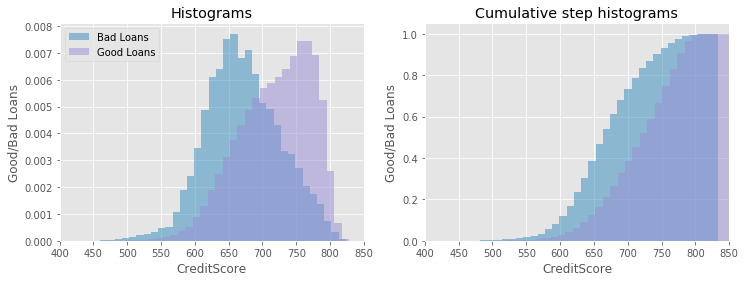

In [28]:
good_loans = data_filled[data_filled['IsBadLoan']==0]
bad_loans  = data_filled[data_filled['IsBadLoan']==1]

# for continuous variables
col = 'CreditScore'
nbins = 50

fig, ax = plt.subplots(1,2,figsize=(12, 4))
_ = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label='Good Loans', alpha = 0.5, color='C2')

_ = ax[1].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[1].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Good/Bad Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Histograms')

ax[1].set_xlim(400, 850)
ax[1].set_xlabel(col)
ax[1].set_ylabel('Good/Bad Loans')
# ax[1].legend(loc='upper left')
ax[1].set_title('Cumulative step histograms')

plt.show();

# apparently important 

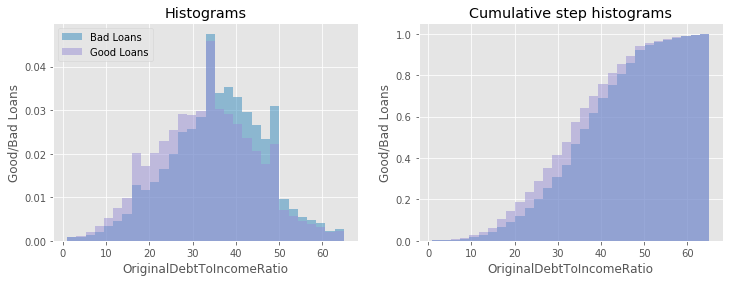

In [29]:
col = 'OriginalDebtToIncomeRatio'
nbins = 30

fig, ax = plt.subplots(1,2,figsize=(12, 4))
_ = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=False, label='Good Loans', alpha = 0.5, color='C2')

_ = ax[1].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
_ = ax[1].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

# ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Good/Bad Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Histograms')

# ax[1].set_xlim(400, 850)
ax[1].set_xlabel(col)
ax[1].set_ylabel('Good/Bad Loans')
# ax[1].legend(loc='upper left')
ax[1].set_title('Cumulative step histograms')

plt.show();

# less important

In [30]:
# categoral variables

### Split data into train, val, and test

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

def split_n_transform(df, features, target, pipeline=None, fit=True):
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),  # missing values: disregarded in fit, and maintained in transform
    ])
    """
    
    X = df[features]
    if pipeline:
        if fit: 
            X = pipeline.fit_transform(X)
        else:
            X = pipeline.transform(X)
    else:
        fit = False
        
    y = df[target].to_numpy(int)
    
    if fit:
        return X, y, pipeline
    else:
        return X, y

In [32]:
target = 'IsBadLoan'
features = data_filled.columns.drop(cat_cols+[target, 'FirstPaymentDate'])  # all features but firstpaymentdate

In [33]:
from sklearn.model_selection import train_test_split

# use all features
trainval = data_filled[data_filled.FirstPaymentDate<200300]
test  = data_filled[data_filled.FirstPaymentDate>200300]

train, val = train_test_split(trainval, test_size=0.15, stratify=trainval.IsBadLoan)

# X_trainval, y_trainval = split_n_transform( trainval, features, target)
# X_test,  y_test  = split_n_transform( test, features, target)

# X_train, y_train  = split_n_transform( train, features, target)
# X_val, y_val  = split_n_transform(val, features, target)

In [35]:
np.sum(train[target]==1)/len(train), np.sum(test[target]==1)/len(test)
# there are quite big difference (almost 1/3, but at current stage, this not what we can know immediately from history)

(0.0214538905923817, 0.021454715736962317, 0.0276829982303757)

# Balanced Classification Strategy

## Under-sampling

In [34]:
def under_sample_df(df, target, target_val=1):
    shuffle = df.sample(frac=1, random_state=4) # Not needed, but is ok to keep
    
    shuffle_bad = shuffle.loc[shuffle[target] == target_val]
    shuffle_good_subsample = shuffle.loc[shuffle[target] != target_val].sample(n=len(shuffle_bad),random_state=42)
    
    combined = pd.concat([shuffle_good_subsample, shuffle_bad])
    
    return combined.sample(frac=1,random_state=4)

In [35]:
train_under = under_sample_df(train, target)
trainval_under = under_sample_df(trainval, target)

#X_train_under, y_train_under = split_n_transform( train_under, features, target)

## Over-sampling

In [36]:
from imblearn.over_sampling import SMOTE, SMOTENC # SMOTENC for catigorical variables

def over_sample_df(df_inp, features, target, cat_cols=None):
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.

    df = df_inp[features].copy()
    
    if cat_cols is None:
        sm = SMOTE(sampling_strategy='minority', random_state=7, n_jobs=16)
    else:
        for col in features:
            if col in cat_cols: 
                continue
            df[col] = df[col].astype(float) # int variables not accepted for smote
        sm = SMOTENC(features.isin(cat_cols), sampling_strategy='minority', random_state=7, n_jobs=16)
    
    # Fit the model to generate the data.
    over_X, over_y= sm.fit_sample(df, df_inp[target].to_numpy(int))
    
    oversampled = pd.concat([pd.DataFrame(over_X, columns=features), pd.DataFrame(over_y, columns=[target])], axis=1)

    return oversampled.sample(frac=1,random_state=4)

In [37]:
# cat_features are the features will be treated as categrical ones (and integeral ones)
cat_features =   ['FirstTimeHomebuyerFlag', 'PrepaymentPenaltyMortgageFlag'] \
                +['OccupancyStatus_cat', 'Channel_cat', 'PropertyState_cat', 
                  'PropertyType_cat', 'LoanPurpose_cat', 'SellerName_cat', 
                  'ServicerName_cat', 'MetropolitanStatisticalArea_cat', 'PostalCode_cat'] \
                +['NumberOfUnits', 'NumberOfBorrowers']

train_over = over_sample_df(train, features, target, cat_features)
trainval_over = over_sample_df(trainval, features, target, cat_features)

#X_train_over, y_train_over = split_n_transform( train_over, features, target)

In [111]:
# save the data for future convenience

data_filled.to_csv('data_filled.csv.gz', index=False)

train_under.to_csv('train_under_new.csv.gz', index=False)
trainval_under.to_csv('trainval_under_new.csv.gz', index=False)

train_over.to_csv('train_over_new.csv.gz', index=False)
trainval_over.to_csv('trainval_over_new.csv.gz', index=False)

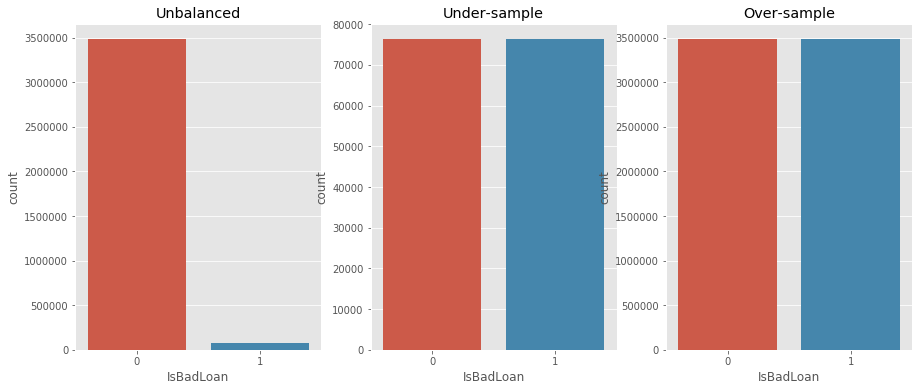

In [38]:
# show the effects of resampling

fig, ax = plt.subplots(1,3,figsize=(15, 6))

sns.countplot('IsBadLoan', data=train, ax=ax[0])
ax[0].title.set_text('Unbalanced')

sns.countplot('IsBadLoan', data=train_under, ax=ax[1])
ax[1].title.set_text('Under-sample')

sns.countplot('IsBadLoan', data=train_over, ax=ax[2])
ax[2].title.set_text('Over-sample')

plt.show();

## Correlation Plots

Text(0.5, 1, 'Correlation Matrix Undersample')

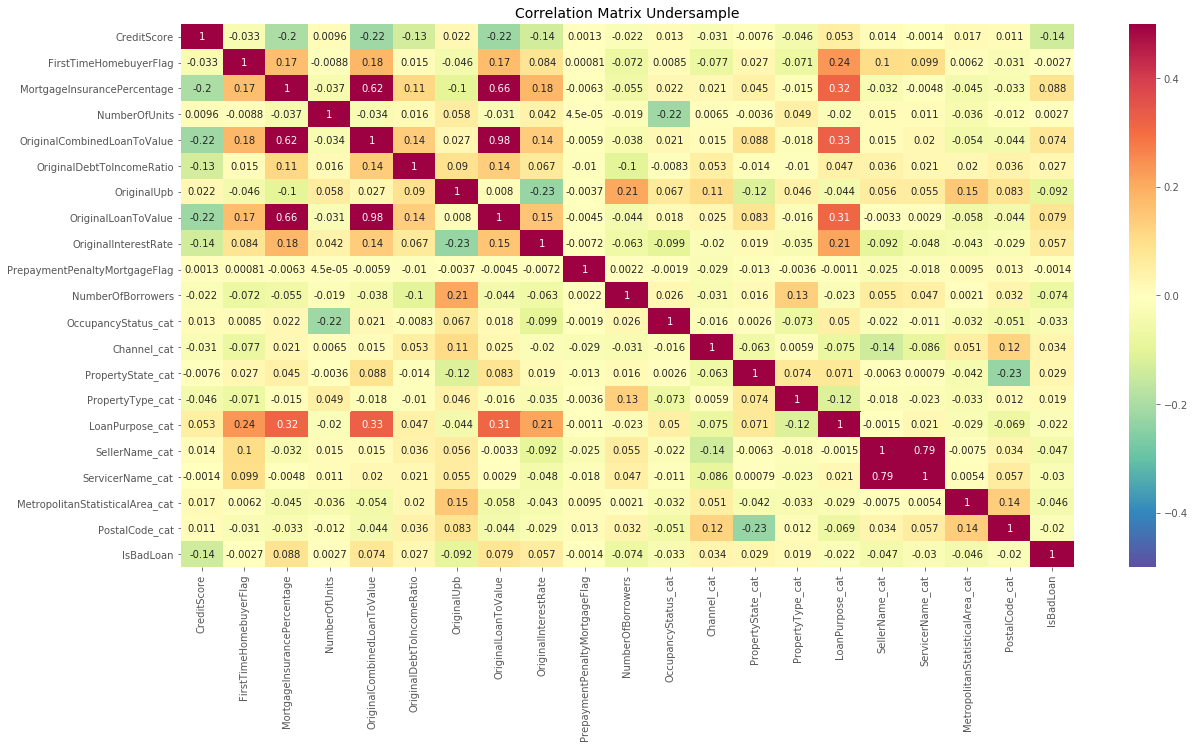

In [129]:
# un-resampled

fig, ax = plt.subplots(figsize=(20,10))         
corr = train[features.to_list()+[target]].corr()
sns.heatmap(corr, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.savefig('correlation.png')
#plt.show();

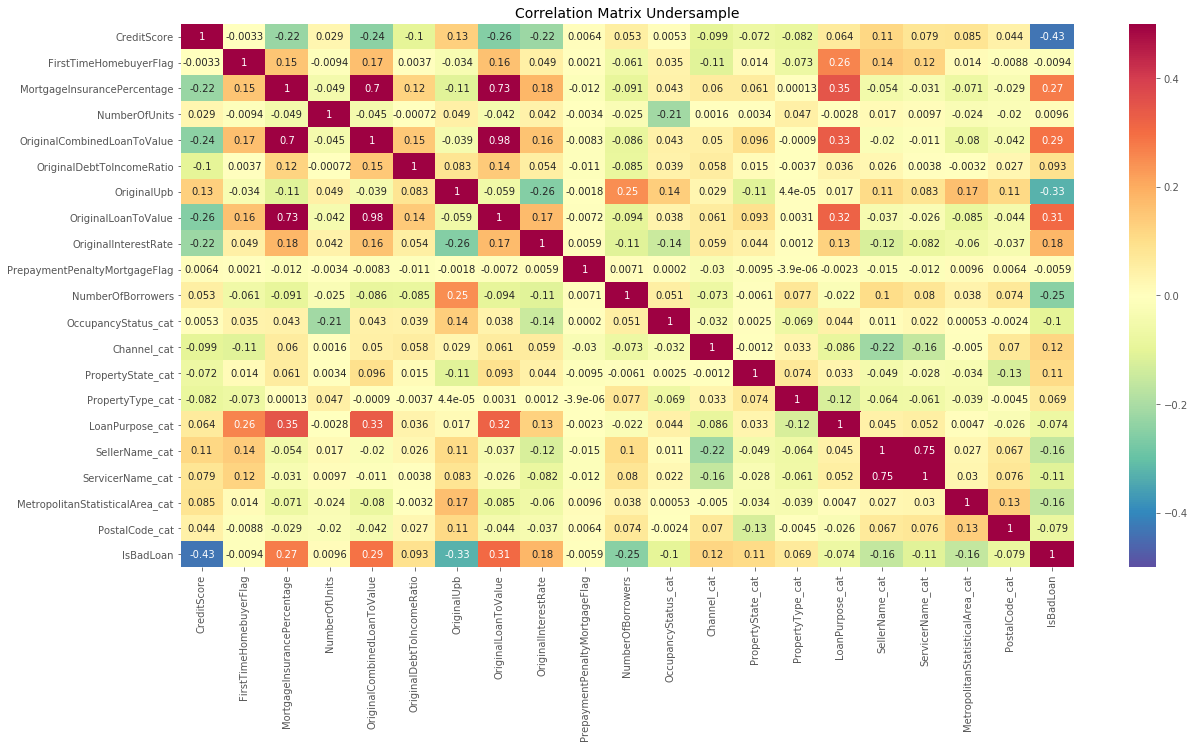

In [40]:
# under sampled
fig, ax = plt.subplots(figsize=(20,10))         
corr_under = train_under[features.to_list()+[target]].corr()
sns.heatmap(corr_under, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show();

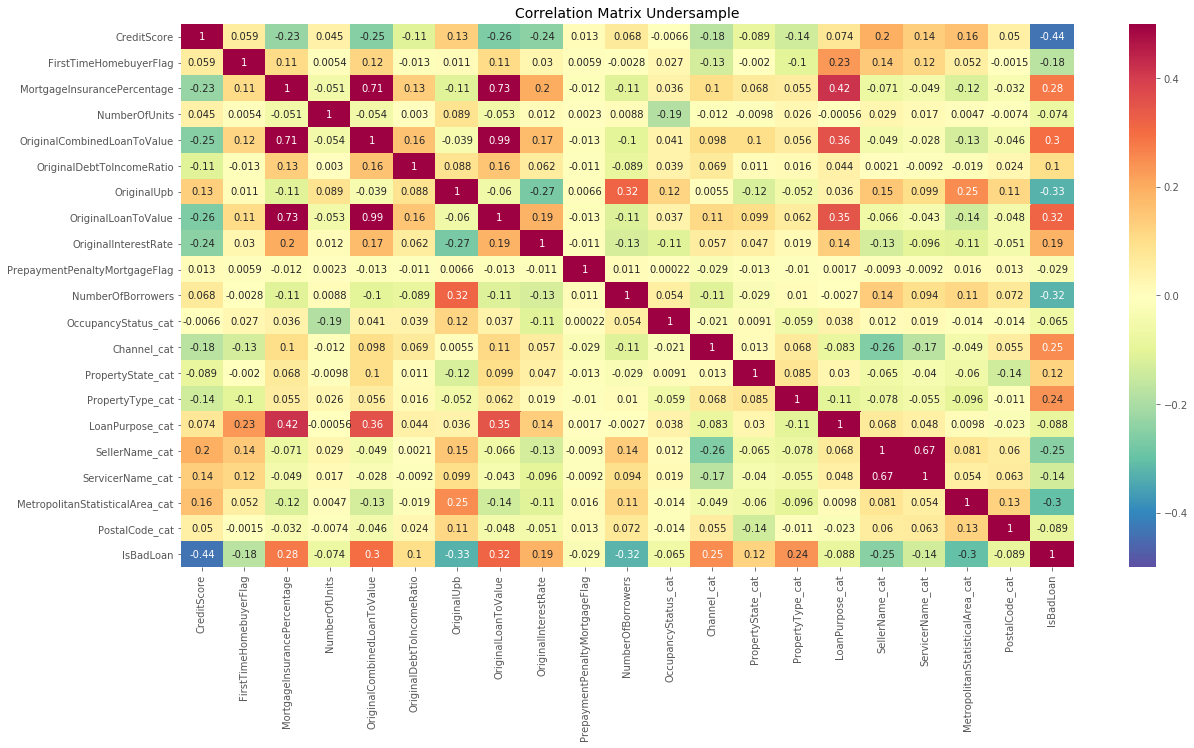

In [41]:
#over sampled
fig, ax = plt.subplots(figsize=(20,10))         
corr_over = train_over.corr()
sns.heatmap(corr_over, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show();

In [42]:
pd.concat([corr.IsBadLoan, corr_under.IsBadLoan, corr_over.IsBadLoan], axis=1).T.set_index(pd.Index(['Unbalanced', 'UnderSampled', 'OverSampled']))

# the difference is quite big

,CreditScore,FirstTimeHomebuyerFlag,MortgageInsurancePercentage,NumberOfUnits,OriginalCombinedLoanToValue,OriginalDebtToIncomeRatio,OriginalUpb,OriginalLoanToValue,OriginalInterestRate,PrepaymentPenaltyMortgageFlag,NumberOfBorrowers,OccupancyStatus_cat,Channel_cat,PropertyState_cat,PropertyType_cat,LoanPurpose_cat,SellerName_cat,ServicerName_cat,MetropolitanStatisticalArea_cat,PostalCode_cat,IsBadLoan
Unbalanced,-0.137396,-0.002674,0.087768,0.002679,0.074276,0.026963,-0.091910,0.079334,0.056742,-0.001366,-0.073550,-0.032651,0.034435,0.029049,0.018901,-0.021924,-0.047340,-0.030011,-0.046365,-0.020074,1.0
UnderSampled,-0.431108,-0.009378,0.274792,0.009641,0.289567,0.093257,-0.325001,0.305512,0.180639,-0.005903,-0.247108,-0.100682,0.118561,0.105539,0.069186,-0.073542,-0.158760,-0.106361,-0.156375,-0.078792,1.0
OverSampled,-0.435656,-0.175630,0.277808,-0.073879,0.300241,0.101124,-0.325785,0.318826,0.189777,-0.028899,-0.321871,-0.064930,0.252943,0.122995,0.239235,-0.088081,-0.248083,-0.135277,-0.303446,-0.088836,1.0


## Modelling

In [43]:
from sklearn.metrics import *

def plot_pr_curve(y_true, probas_pred, label=None):
    pre, tpr, thres = precision_recall_curve(y_true, probas_pred)
    plt.plot(tpr, pre, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall (True Positive Rate)', fontsize=16)
    plt.ylabel('Precision (PPV)', fontsize=16)
    plt.show();

def plot_roc_curve(y_true, probas_pred, label=None):
    fpr, tpr, thres = roc_curve(y_true, probas_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show();
    

def prediction_summary(clf_name, session_name, y, pred, threshold=None):
    summary = []
    summary.append(('Algo', clf_name))
    summary.append(('Dataset', session_name))

    summary.append(('ROCAUC', roc_auc_score(y, pred)))
    summary.append(('PRCAUC', average_precision_score(y,pred)))
    
    if threshold is None:
        pred_ = np.unique(pred)
        if len(pred_) == 2:
            threshold = 0.5
        else:
            scores = [(balanced_accuracy_score(y, pred>thresh), thresh) 
                                     for thresh in np.concatenate((np.arange(1,10)*0.01, np.arange(0.1,0.6,0.1)))]  # I tried to cover the 0.02 imbalance here
                                                                                                                    # should not be hardcoded like this
            threshold = max(scores)[1]
                
    summary.append(('Threshold', threshold))
    summary.append(('Accuracy', accuracy_score(y, pred>threshold)))
    summary.append(('BalancedAccuracy', balanced_accuracy_score(y, pred>threshold)))
    summary.append(('F1Score', f1_score(y, pred>threshold)))
    summary.append(('MatthewsCC', matthews_corrcoef(y,pred>threshold) ))
    summary += list(zip('Precision Recall FScore Support'.split(), precision_recall_fscore_support(y,pred>threshold)))
    summary.append(('ConfusionMatrix', confusion_matrix(y, pred>threshold)))
    
    return pd.Series(dict(summary)).to_frame().T

In [44]:
# reuse the function, adding the parameter of cat_features, modified some default parameters, use predicted probability directly

import time
import lightgbm as lgb

cat_features_lgb =['FirstTimeHomebuyerFlag', 'PrepaymentPenaltyMortgageFlag'] \
                 +['OccupancyStatus_cat', 'Channel_cat', 'PropertyState_cat', 
                   'PropertyType_cat', 'LoanPurpose_cat', 'SellerName_cat', 
                   'ServicerName_cat', 'MetropolitanStatisticalArea_cat', 'PostalCode_cat']  \
                 +['NumberOfUnits', 'NumberOfBorrowers']

# the last two are reasonable, since they are usually 1 and 2

def lgb_pr_auc(y_pred, y_true):
    return 'pr_auc', average_precision_score(y_true.get_label(), y_pred), True

def call_lgb(train, valid, test, features, target, cat_features, is_unbalanced_flag=False, lgb_params=None, threshold=None):
    start_time = time.time()

    dtrain = lgb.Dataset(train[features], label=train[target])
    dvalid = lgb.Dataset(valid[features], label=valid[target])
    if test is not None:
        dtest  = lgb.Dataset( test[features], label= test[target])

    param = {'num_leaves': 63, 'objective': 'binary', 'learning_rate':0.1, 'is_unbalance': is_unbalanced_flag}
    param['metric'] = 'auc' # default logloss
    if lgb_params: 
        param.update(lgb_params)
        
    num_round = 1000
    bst = lgb.train(param, dtrain, num_boost_round=num_round, valid_sets=[dvalid],
                    feature_name='auto', categorical_feature=cat_features, verbose_eval=100, early_stopping_rounds=20)

    ypred_train = bst.predict(train[features], num_iteration=bst.best_iteration)
    ypred_valid = bst.predict(valid[features], num_iteration=bst.best_iteration)
    if test is not None:
        ypred_test  = bst.predict( test[features], num_iteration=bst.best_iteration)   

    importance = pd.DataFrame(data = bst.feature_importance(), index = bst.feature_name(), columns = ['Importance'])
    importance = importance.sort_values(by='Importance', ascending = False)
    
    summary = prediction_summary('Light LGB',  'Training', train[target], ypred_train, threshold)
    summary = summary.append( prediction_summary('Light LGB','Valdiation', valid[target], ypred_valid, threshold),
                              ignore_index=True)
    if test is not None:
        thresh = summary.Threshold.values[-1] # threshold determined from validation
        summary = summary.append( prediction_summary('Light LGB',   'Testing',  test[target],  ypred_test, threshold=thresh),
                                  ignore_index=True)

    print("--- %s seconds ---" % (time.time() - start_time))     
    return bst, importance, summary


def final_lgb(train, test, features, target, cat_features, num_round, threshold, is_unbalanced_flag=False, lgb_params=None):
    start_time = time.time()

    dtrain = lgb.Dataset(train[features], label=train[target])
    if test is not None:
        dtest  = lgb.Dataset( test[features], label= test[target])

    param = {'num_leaves': 63, 'objective': 'binary', 'learning_rate':0.1, 'is_unbalance': is_unbalanced_flag}
    param['metric'] = 'auc' # default logloss
    if lgb_params: 
        param.update(lgb_params)
        
    bst = lgb.train(param, dtrain, num_boost_round=num_round, 
                    feature_name='auto', categorical_feature=cat_features, verbose_eval=100)

    ypred_train = bst.predict(train[features], num_iteration=bst.best_iteration)
    if test is not None:
        ypred_test  = bst.predict( test[features], num_iteration=bst.best_iteration)   

    importance = pd.DataFrame(data = bst.feature_importance(), index = bst.feature_name(), columns = ['Importance'])
    importance = importance.sort_values(by='Importance', ascending = False)
    
    summary = prediction_summary('Light LGB',  'Training', train[target], ypred_train)
    if test is not None:
        summary = summary.append( prediction_summary('Light LGB',   'Testing',  test[target],  ypred_test, threshold),
                                  ignore_index=True)

    print("--- %s seconds ---" % (time.time() - start_time))     
    return bst, importance, summary

### Without any treatment

In [45]:
bst_plain, imp_plain, metrics_plain = call_lgb(train, val, None, features, target, cat_features_lgb, 
                                               is_unbalanced_flag=False, lgb_params=None, threshold=None)
imp_plain
metrics_plain

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.903593
Early stopping, best iteration is:
[84]	valid_0's auc: 0.903719
--- 402.8101980686188 seconds ---


,Importance
PostalCode_cat,2582
MetropolitanStatisticalArea_cat,622
ServicerName_cat,381
CreditScore,305
SellerName_cat,272
OriginalUpb,168
OriginalLoanToValue,136
OriginalInterestRate,110
OriginalDebtToIncomeRatio,92
LoanPurpose_cat,92


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.929036,0.339607,0.02,0.809438,0.849867,0.167271,0.250066,"[0.9970796816055049, 0.09228746654016874]","[0.8076251595624284, 0.8921089522711492]","[0.8924081307744093, 0.16727097642700625]","[3481396, 76327]","[[2811663, 669733], [8235, 68092]]"
1,Light LGB,Valdiation,0.903719,0.262133,0.02,0.807393,0.821894,0.15717,0.230208,"[0.9955908554945574, 0.08672743356024769]","[0.8067432336530135, 0.8370452858203415]","[0.8912733671224329, 0.15717023871754662]","[614364, 13470]","[[495634, 118730], [2195, 11275]]"


In [46]:
bst_plain, imp_plain, metrics_plain = final_lgb(trainval, test, features, target, cat_features_lgb, 
                                                bst_plain.best_iteration, metrics_plain.Threshold.values[-1], is_unbalanced_flag=True, lgb_params=None)

imp_plain
metrics_plain

--- 401.3809463977814 seconds ---


,Importance
PostalCode_cat,2931
MetropolitanStatisticalArea_cat,766
ServicerName_cat,309
SellerName_cat,237
CreditScore,190
OriginalUpb,132
PropertyState_cat,122
OriginalCombinedLoanToValue,72
OriginalLoanToValue,71
OriginalInterestRate,68


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.929372,0.284675,0.5,0.818069,0.854126,0.173778,0.257159,"[0.997102908184016, 0.09626867376170435]","[0.816452135867336, 0.8918003942225241]","[0.8977800830878125, 0.17377821853509917]","[4095760, 89797]","[[3343992, 751768], [9716, 80081]]"
1,Light LGB,Testing,0.816836,0.157157,0.02,0.188173,0.578018,0.0632896,0.0696525,"[0.9984030780755218, 0.03268893758992594]","[0.16532355596100404, 0.9907123195437353]","[0.28367409032708707, 0.06328960993040142]","[1773619, 50497]","[[293221, 1480398], [469, 50028]]"


### use the flag is_unbalanced

In [47]:
bst_bal, imp_bal, metrics_bal = call_lgb(train, val, None, features, target, cat_features_lgb, 
                                         is_unbalanced_flag=True, lgb_params=None, threshold=None)
imp_bal
metrics_bal

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.894746
Early stopping, best iteration is:
[114]	valid_0's auc: 0.894918
--- 403.72278022766113 seconds ---


,Importance
PostalCode_cat,4049
MetropolitanStatisticalArea_cat,1094
ServicerName_cat,378
SellerName_cat,360
CreditScore,220
OriginalUpb,177
PropertyState_cat,124
OriginalCombinedLoanToValue,113
OriginalInterestRate,96
OriginalLoanToValue,72


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.939491,0.306484,0.5,0.83315,0.870658,0.189614,0.276946,"[0.9976285097177338, 0.10583505544278024]","[0.831468181154916, 0.9098484153707076]","[0.9070011077955058, 0.1896139107357143]","[3481396, 76327]","[[2894670, 586726], [6881, 69446]]"
1,Light LGB,Valdiation,0.894918,0.239643,0.4,0.786737,0.814607,0.145125,0.217303,"[0.9956569282825782, 0.0793900275228076]","[0.7854871053642466, 0.8437268002969562]","[0.8781723024737864, 0.14512462968638265]","[614364, 13470]","[[482575, 131789], [2105, 11365]]"


In [48]:
bst_bal, imp_bal, metrics_bal = final_lgb(trainval, test, features, target, cat_features_lgb, 
                                          bst_bal.best_iteration, metrics_bal.Threshold.values[-1], is_unbalanced_flag=True, lgb_params=None)
imp_bal
metrics_bal

--- 410.38944911956787 seconds ---


,Importance
PostalCode_cat,4028
MetropolitanStatisticalArea_cat,1105
ServicerName_cat,399
SellerName_cat,347
CreditScore,230
OriginalUpb,173
PropertyState_cat,149
OriginalCombinedLoanToValue,94
OriginalLoanToValue,90
OriginalInterestRate,88


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.935867,0.299514,0.5,0.827176,0.863991,0.183045,0.268822,"[0.997416157115583, 0.10185195658867963]","[0.8255251772564799, 0.9024577658496387]","[0.9033665915364713, 0.18304530392730414]","[4095760, 89797]","[[3381153, 714607], [8759, 81038]]"
1,Light LGB,Testing,0.818399,0.160202,0.4,0.756602,0.737689,0.140338,0.178834,"[0.9895026090695631, 0.07777341411123916]","[0.7577106469878818, 0.7176663960235261]","[0.858231425974993, 0.14033837658238876]","[1773619, 50497]","[[1343890, 429729], [14257, 36240]]"


### Use resampled training set

In [49]:
# over sampling data

bst_over, imp_over, metrics_over = call_lgb(train_over, val, None, features, target, cat_features_lgb, 
                                            is_unbalanced_flag=False, lgb_params=None, threshold=None)
imp_over
metrics_over

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.883265
[200]	valid_0's auc: 0.894957
[300]	valid_0's auc: 0.896425
Early stopping, best iteration is:
[299]	valid_0's auc: 0.89644
--- 909.430534362793 seconds ---


,Importance
PostalCode_cat,7213
MetropolitanStatisticalArea_cat,2364
OriginalDebtToIncomeRatio,1933
OriginalInterestRate,1797
SellerName_cat,720
PropertyState_cat,715
ServicerName_cat,657
OriginalLoanToValue,563
OriginalCombinedLoanToValue,559
CreditScore,479


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.998466,0.998707,0.5,0.988839,0.988839,0.988741,0.977826,"[0.9804941416357907, 0.9974790503058668]","[0.9975228327946606, 0.9801553744532365]","[0.9889351874593761, 0.9887413364387585]","[3481396, 3481396]","[[3472772, 8624], [69087, 3412309]]"
1,Light LGB,Valdiation,0.89644,0.24363,0.02,0.77786,0.815372,0.141683,0.214805,"[0.9959086494783999, 0.07724518350009059]","[0.7761782916967791, 0.85456570155902]","[0.8724207106064058, 0.14168343703266068]","[614364, 13470]","[[476856, 137508], [1959, 11511]]"


In [50]:
bst_over, imp_over, metrics_over = final_lgb(trainval_over, test, features, target, cat_features_lgb, 
                                             bst_over.best_iteration, metrics_over.Threshold.values[-1], is_unbalanced_flag=True, lgb_params=None)

imp_over
metrics_over

--- 989.8107995986938 seconds ---


,Importance
PostalCode_cat,7238
MetropolitanStatisticalArea_cat,2363
OriginalInterestRate,1969
OriginalDebtToIncomeRatio,1915
PropertyState_cat,703
SellerName_cat,689
ServicerName_cat,636
OriginalCombinedLoanToValue,609
OriginalLoanToValue,554
CreditScore,409


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.998372,0.998638,0.5,0.988694,0.988694,0.988592,0.977542,"[0.9801498810163507, 0.9975470309827785]","[0.9975906791413559, 0.9797966677735024]","[0.9887933788296791, 0.9885921780002562]","[4095760, 4095760]","[[4085892, 9868], [82748, 4013012]]"
1,Light LGB,Testing,0.828178,0.162777,0.02,0.743295,0.747584,0.139576,0.182845,"[0.9905915089815498, 0.07692588136643698]","[0.7430440246749724, 0.7521238885478345]","[0.8491439952087829, 0.1395761632725061]","[1773619, 50497]","[[1317877, 455742], [12517, 37980]]"


In [51]:
# under sampling data

bst_under, imp_under, metrics_under = call_lgb(train_under, val, None, features, target, cat_features_lgb, 
                                               is_unbalanced_flag=False, lgb_params=None, threshold=None)
imp_under
metrics_under

Training until validation scores don't improve for 20 rounds
[100]	valid_0's auc: 0.900733
Early stopping, best iteration is:
[92]	valid_0's auc: 0.900768
--- 80.0864782333374 seconds ---


,Importance
PostalCode_cat,2627
MetropolitanStatisticalArea_cat,754
ServicerName_cat,404
SellerName_cat,328
CreditScore,288
OriginalUpb,192
OriginalLoanToValue,172
PropertyState_cat,150
OriginalInterestRate,129
NumberOfBorrowers,129


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.943265,0.940061,0.5,0.867177,0.867177,0.869599,0.734861,"[0.8813460151583187, 0.8540227126309008]","[0.8485987920395142, 0.8857547132731537]","[0.8646624571146324, 0.8695993311466975]","[76327, 76327]","[[64771, 11556], [8720, 67607]]"
1,Light LGB,Valdiation,0.900768,0.231186,0.5,0.80283,0.82116,0.154602,0.227794,"[0.9956534566234774, 0.08513214699378752]","[0.8020082556920652, 0.8403118040089087]","[0.8884010673974972, 0.15460157893299098]","[614364, 13470]","[[492725, 121639], [2151, 11319]]"


In [52]:
bst_under, imp_under, metrics_under = final_lgb(trainval_under, test, features, target, cat_features_lgb, 
                                                bst_under.best_iteration, metrics_under.Threshold.values[-1], is_unbalanced_flag=False, lgb_params=None)
imp_under
metrics_under

--- 48.49404215812683 seconds ---


,Importance
PostalCode_cat,2702
MetropolitanStatisticalArea_cat,741
ServicerName_cat,411
SellerName_cat,341
CreditScore,279
OriginalUpb,197
OriginalLoanToValue,173
NumberOfBorrowers,125
OriginalCombinedLoanToValue,114
LoanPurpose_cat,111


,Algo,Dataset,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Light LGB,Training,0.94045,0.937411,0.5,0.86357,0.86357,0.866093,0.727657,"[0.8778077372617547, 0.850366491022848]","[0.8447275521453946, 0.8824125527578872]","[0.8609500028375234, 0.8660931915312223]","[89797, 89797]","[[75854, 13943], [10559, 79238]]"
1,Light LGB,Testing,0.82556,0.159257,0.5,0.783385,0.740678,0.15093,0.188399,"[0.989087773949881, 0.08465040940436908]","[0.7858886265877847, 0.6954670574489573]","[0.8758570897154261, 0.15093001667497552]","[1773619, 50497]","[[1393867, 379752], [15378, 35119]]"


In [91]:
summary = pd.DataFrame()
for df in [metrics_plain, metrics_bal, metrics_over, metrics_under]:
    summary = summary.append(df[df.Dataset=='Testing'])
summary['is_unbalanced'] = [False, True, False, False]
summary['Dataset'] = ['Orignial', 'Original', 'OverSampled', 'UnderSampled']
summary.drop('Algo', axis=1, inplace=True)
summary.reset_index(drop=True, inplace=True)

for col in 'Precision Recall FScore Support'.split():
    summary[col] = summary[col].apply(np.round, decimals=6)
    
# reorder
summary = summary[['Dataset', 'is_unbalanced']+summary.columns[1:-1].to_list()]

summary

,Dataset,is_unbalanced,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Orignial,False,0.816836,0.157157,0.02,0.188173,0.578018,0.0632896,0.0696525,"[0.998403, 0.032689]","[0.165324, 0.990712]","[0.283674, 0.06329]","[1773619, 50497]","[[293221, 1480398], [469, 50028]]"
1,Original,True,0.818399,0.160202,0.4,0.756602,0.737689,0.140338,0.178834,"[0.989503, 0.077773]","[0.757711, 0.717666]","[0.858231, 0.140338]","[1773619, 50497]","[[1343890, 429729], [14257, 36240]]"
2,OverSampled,False,0.828178,0.162777,0.02,0.743295,0.747584,0.139576,0.182845,"[0.990592, 0.076926]","[0.743044, 0.752124]","[0.849144, 0.139576]","[1773619, 50497]","[[1317877, 455742], [12517, 37980]]"
3,UnderSampled,False,0.82556,0.159257,0.5,0.783385,0.740678,0.15093,0.188399,"[0.989088, 0.08465]","[0.785889, 0.695467]","[0.875857, 0.15093]","[1773619, 50497]","[[1393867, 379752], [15378, 35119]]"


### Prediction based on the Credit Score

Credit Score > 720, Recall (TPR): 0.7502, TNR: 0.4703


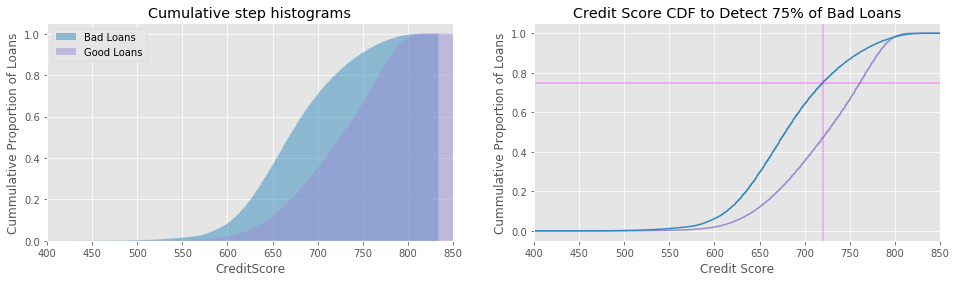

In [109]:
good_loans = data_filled[data_filled['IsBadLoan']==0]
bad_loans  = data_filled[data_filled['IsBadLoan']==1]

# for continuous variables
col = 'CreditScore'
nbins = 1000

fig, ax = plt.subplots(1,2,figsize=(16, 4))

n_bad, bins, patches = ax[0].hist( bad_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label= 'Bad Loans', alpha = 0.5, color='C1')
n_good, bins, patches = ax[0].hist(good_loans[col], nbins, density=True, histtype='stepfilled',
                           cumulative=True, label='Good Loans', alpha = 0.5, color='C2')

idx = (n_bad>0.75).argmax()

print(f'Credit Score > {int(bins[idx])}, Recall (TPR): {n_bad[idx]:.4f}, TNR: {n_good[idx]:.4f}')

ax[0].set_xlim(400, 850)
ax[0].set_xlabel(col)
ax[0].set_ylabel('Cummulative Proportion of Loans')
ax[0].legend(loc='upper left')
ax[0].set_title('Cumulative step histograms')

ax[1].plot(bins[:-1],n_good, color='C2')
ax[1].plot(bins[:-1],n_bad, color='C1')
ax[1].axhline(0.75, color='magenta', alpha=0.3)
ax[1].axvline( 720, color='magenta', alpha=0.3)
ax[1].set_title('Credit Score CDF to Detect 75% of Bad Loans')
ax[1].set_xlabel('Credit Score')
ax[1].set_ylabel('Cummulative Proportion of Loans')
ax[1].set_xlim(400,850)

plt.show();

### Summary <a id='summary'></a>

In [110]:
summary

,Dataset,is_unbalanced,ROCAUC,PRCAUC,Threshold,Accuracy,BalancedAccuracy,F1Score,MatthewsCC,Precision,Recall,FScore,Support,ConfusionMatrix
0,Orignial,False,0.816836,0.157157,0.02,0.188173,0.578018,0.0632896,0.0696525,"[0.998403, 0.032689]","[0.165324, 0.990712]","[0.283674, 0.06329]","[1773619, 50497]","[[293221, 1480398], [469, 50028]]"
1,Original,True,0.818399,0.160202,0.4,0.756602,0.737689,0.140338,0.178834,"[0.989503, 0.077773]","[0.757711, 0.717666]","[0.858231, 0.140338]","[1773619, 50497]","[[1343890, 429729], [14257, 36240]]"
2,OverSampled,False,0.828178,0.162777,0.02,0.743295,0.747584,0.139576,0.182845,"[0.990592, 0.076926]","[0.743044, 0.752124]","[0.849144, 0.139576]","[1773619, 50497]","[[1317877, 455742], [12517, 37980]]"
3,UnderSampled,False,0.82556,0.159257,0.5,0.783385,0.740678,0.15093,0.188399,"[0.989088, 0.08465]","[0.785889, 0.695467]","[0.875857, 0.15093]","[1773619, 50497]","[[1393867, 379752], [15378, 35119]]"


The numbers, used as metrics, make more sense now.
* We see over-sampling helps to improve the prediction noticeably.
* We see the result from using the under-sampled training set is similar to that from training the model with the original data and is_unbalanced=True, since the latter internally invokes the under-sampling
* The threshold is 0.02 (determined by the validation set) for the model based on the over-sampled training set. That is close to the ratio of positive/negative classes.
* I have not fully understood yet why the optimal threshold is 0.5 for the under-sampled training set case.
* ROC-AUC and PRC-AUC are suitible metric since they do not depends on the threshold. (In Tso's original notebook, the threshold is fixed at 0.5 to calculate these metrics which is not appropriate.)

Comparing to the rsults from **LGB with is_unbalanced=True**, after choosing a better threshold, the Recall increase from 0.72 to 0.75, and the (True Negative Rate) TNR change only from 0.758 to 0.743. Or from the confusion matrix, (14257-12517)=1740 more bad loans are correctly tagged at the price of (455742-429729)=26013 good loans are predicted wrongly. Both are much better than using Credit Score only, with which to achieve a recall of 0.75, the TNR will be 47%.

At last, in this notebook the balanced accuracy was used to select the optimal threshold based on the validation set. The balanced accuracy is the average of TPR (Recall) and TNR (specificity), and one may design a better one taking into account of the buisiness insight, such as a weighted average to reflect the cost and gain.

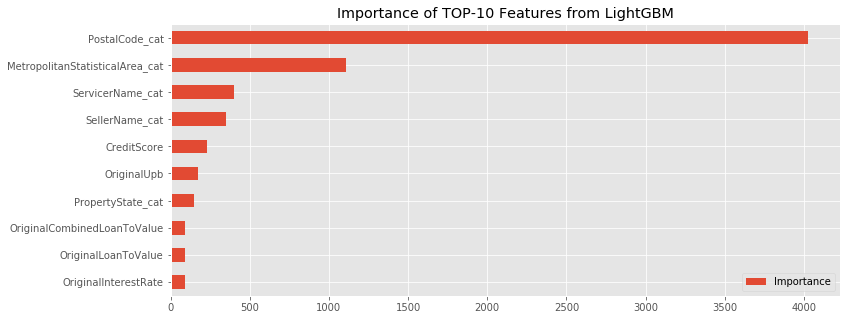

In [128]:
imp_bal.sort_values(by='Importance',ascending=True).tail(10).plot.barh(figsize=(12,5))
plt.title("Importance of TOP-10 Features from LightGBM")
plt.savefig('importance.png');

An interesting thing is that the Credit Score seems not that important in this model, which showes the strongest correlation with the target. The four categorical variables with higher importance are all related to the location. This should imply some kind of clustering, and that may be used to improve the model.   